In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator

# train_data_dir = 'C:/Users/abbas/Extracted_features/train_dataset/'
# validation_data_dir = 'C:/Users/abbas/Extracted_features/validation_dataset/'
# num_classes = len(os.listdir('C:/Users/abbas/Extracted_features/validation_dataset/'))

train_data_dir ='C:/Users/abbas/Face_Images/Final_Training_Images/'
validation_data_dir='C:/Users/abbas/Face_Images/Final_Testing_Images/'
num_classes = len(os.listdir('C:/Users/abbas/Face_Images/Final_Training_Images/'))

# train_data_dir = 'C:/Users/abbas/extr_faces/train_dataset/'
# validation_data_dir = 'C:/Users/abbas/extr_faces/validation_dataset/'
# num_classes = len(os.listdir('C:/Users/abbas/extr_faces/train_dataset/'))
img_rows, img_cols = 224, 224 
# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1)
 
validation_datagen = ImageDataGenerator(rescale=1)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 16
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf

img_augmentation = Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.15),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.experimental.preprocessing.RandomFlip(),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)



In [81]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from keras.optimizers import RMSprop

with strategy.scope():
    inputs = layers.Input(shape=(img_rows, img_cols, 3))
#     x = img_augmentation(inputs)
    x = inputs

    outputs = EfficientNetB0(include_top=True, weights=None, classes=num_classes)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=RMSprop(lr = 0.001), loss="categorical_crossentropy", metrics=["accuracy"]
    )

#     for layer in model.layers:
#         layer.trainable = False 

# conv_base = tensorflow.keras.applications.EfficientNetB3(weights='imagenet',
#                   include_top=False,
#                   input_shape=(224, 224, 3)
#                   pooling='max'
#                   )
#include.. flatten layer i being false should use maxpooling for
model.summary()


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 16)                4070067   
Total params: 4,070,067
Trainable params: 4,028,044
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
epochs = 10  # @param {type: "slider", min:10, max:100}

history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
)

training EfficientNet on smaller datasets, especially those with lower resolution increase risk of overfitting

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

In [57]:
def build_model(num_classes):
    inputs = layers.Input(shape=(img_rows, img_cols, 3))
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [62]:
with strategy.scope():
    model = build_model(num_classes=num_classes)



16711680/16705208 [==============================] - 84s 5us/step


In [ ]:
epochs = 50  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, verbose=2)


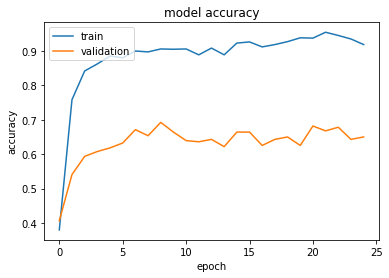

In [69]:
import matplotlib.pyplot as plt

def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [70]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)


In [ ]:
epochs = 50  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, verbose=2)
plot_hist(hist)